# OPEN DATA PROJECT
## Building Sustainability Index (BASIX) 2006 - 2014
### Chenxing Fang 3372128

# What is BASIX?

BASIX is a performance based regulatory scheme that delivers energy and water efficiency outcomes in line with the requirements of the Building Code of Australia.

Introduced in 2004, BASIX applies to all new residential buildings and to alterations and additions to existing residential buildings where the cost of renovation works is more than $50,000.

- investigate trends in BASIX measures
- examine policy outcomes and savings
- identify consumer preferences
- identify business opportunities
- assess broader planning objectives for example, housing and infrastructure demands

In [2]:
import os
import geopandas as gp
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

shp_file_name = "NSW_LOCALITY_POLYGON_shp.shp"
zip_file_name = "nswlocalitypolygonshp.zip"
web_file_path = ("http://data.gov.au/dataset/91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
                 "bf8b5180-fcea-44bd-bd76-af14cc4b0fe0/download/nswlocalitypolygonshp.zip")

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [4]:
saved_style_state = matplotlib.rcParams.copy()

In [5]:
os.path.isfile("Outcomes_Scores.csv")
filepath = "Outcomes_Scores.csv"
scores = pd.read_csv(filepath)
scores = pd.read_csv(filepath,
                     infer_datetime_format=True,
                     parse_dates=['CERTIFICATE DATE'],
                     dayfirst=True)
print "loading from file"
print "done"

loading from file
done


In [6]:
os.path.isfile("SD_Energy.csv")
filepath = "SD_Energy.csv"
energy = pd.read_csv(filepath)
print "loading from file"
print "done"

loading from file
done


In [7]:
os.path.isfile("SD_Water.csv")
filepath = "SD_Water.csv"
water = pd.read_csv(filepath)
print "loading from file"
print "done"

loading from file
done


In [8]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [9]:
if os.path.isfile(shp_file_name):
    print "loading from file"
else:
    if os.path.isfile(zip_file_name):
        print "unzipping"
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print "loading from the internet"
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print "done"

loading from file
done


## Raw Data

In [10]:
scores.shape

(41868, 14)

In [11]:
scores.describe()

,Id,POSTCODE,ENERGY TARGET,WATER TARGET,ENERGY SCORE,WATER SCORE,TOTAL NUMBER BEDROOMS,TOTAL ENERGY SAVINGS PER DAY (KG CO2 PER DAY),TOTAL WATER SAVINGS PER DAY (LITRES PER DAY)
count,41868.000000,41867.000000,41853.000000,41867.000000,41688.000000,41688.000000,41688.000000,41688.000000,41688.000000
mean,200844.428227,2404.723052,35.999689,38.644517,41.312944,43.742588,5.485847,16.586016,518.125231
std,111678.805718,231.278196,8.128142,7.037676,9.676767,11.157102,15.278383,39.723289,1596.266937
min,12137.000000,2000.000000,-1000.000000,-1000.000000,5.000000,0.000000,0.000000,2.460926,0.000000
25%,103995.500000,2179.000000,35.000000,40.000000,40.000000,40.000000,3.000000,9.720232,281.736047
50%,202794.500000,2357.000000,40.000000,40.000000,41.000000,41.000000,4.000000,12.438038,352.086594
75%,286715.750000,2570.000000,40.000000,40.000000,44.000000,45.000000,4.000000,14.364831,411.084128
max,392072.000000,3644.000000,40.000000,40.000000,569.000000,128.000000,754.000000,2299.798480,78487.401123


In [12]:
scores.head()

,Id,CERTIFICATE DATE,REGION,LGA,POSTCODE,SUBURB,DATA SET,ENERGY TARGET,WATER TARGET,ENERGY SCORE,WATER SCORE,TOTAL NUMBER BEDROOMS,TOTAL ENERGY SAVINGS PER DAY (KG CO2 PER DAY),TOTAL WATER SAVINGS PER DAY (LITRES PER DAY)
0,367778,06/NOV/2013,Sydney,The Hills Shire Council,2153.0,BAULKHAM HILLS,single dwellings,40.0,40.0,40.0,40.0,5.0,14.971344,411.084128
1,364678,13/MAY/2014,Sydney,Parramatta City Council,2153.0,BAULKHAM HILLS,single dwellings,40.0,40.0,41.0,40.0,1.0,4.851547,129.964976
2,365298,04/OCT/2013,Sydney,Parramatta City Council,2153.0,BAULKHAM HILLS,single dwellings,40.0,40.0,40.0,40.0,4.0,12.822702,352.086594
3,377036,10/MAR/2014,Sydney,The Hills Shire Council,2153.0,BAULKHAM HILLS,single dwellings,40.0,40.0,41.0,40.0,5.0,15.345627,411.084128
4,370542,14/MAR/2014,Sydney,The Hills Shire Council,2153.0,BAULKHAM HILLS,single dwellings,40.0,40.0,41.0,41.0,4.0,13.143270,360.888759


In [13]:
room_number = scores["TOTAL NUMBER BEDROOMS"].value_counts()
room_number

4.0      20243
3.0       8702
5.0       5291
2.0       2712
6.0       1680
1.0        904
8.0        503
12.0       134
9.0        110
7.0         90
10.0        67
16.0        59
15.0        57
18.0        55
20.0        45
14.0        43
24.0        41
21.0        34
11.0        33
22.0        29
0.0         28
30.0        28
36.0        26
28.0        25
17.0        24
13.0        23
27.0        22
26.0        22
25.0        22
32.0        21
         ...  
348.0        1
125.0        1
297.0        1
185.0        1
236.0        1
246.0        1
178.0        1
427.0        1
204.0        1
222.0        1
190.0        1
366.0        1
184.0        1
264.0        1
162.0        1
155.0        1
666.0        1
141.0        1
275.0        1
167.0        1
172.0        1
152.0        1
186.0        1
303.0        1
199.0        1
171.0        1
463.0        1
500.0        1
143.0        1
227.0        1
Name: TOTAL NUMBER BEDROOMS, dtype: int64

## Building Type Facts

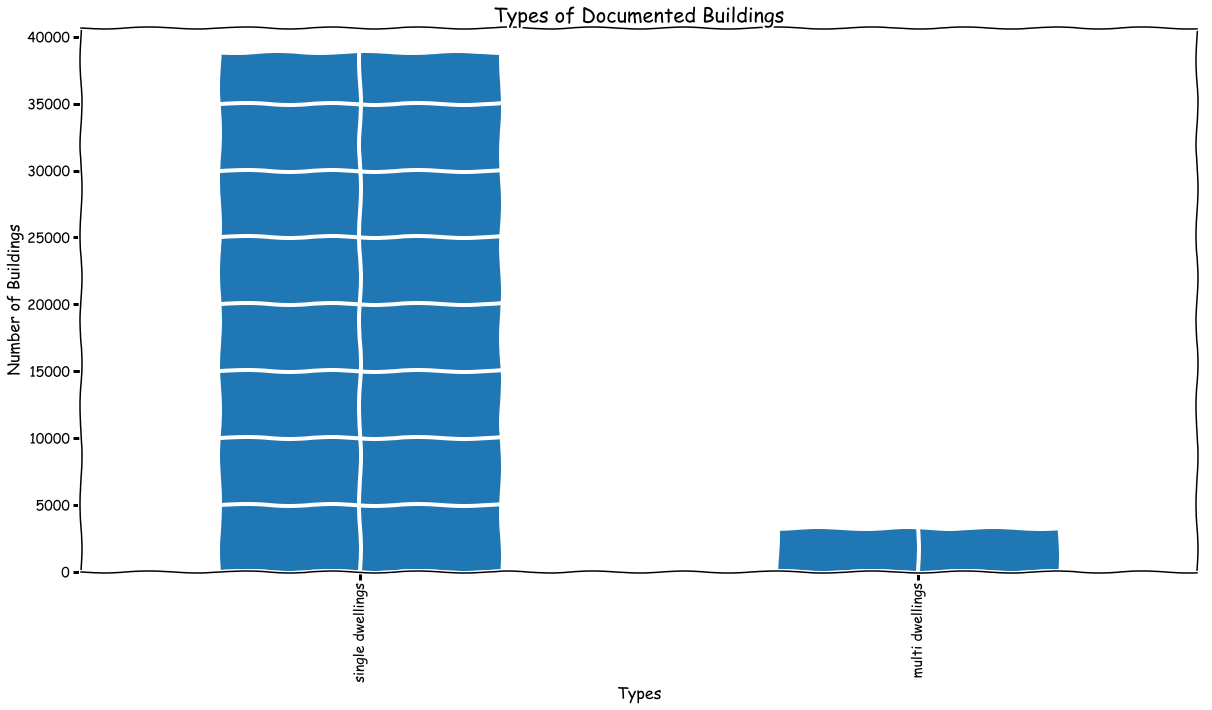

In [17]:
scores["DATA SET"].value_counts().plot(kind="bar")
plt.title("Types of Documented Buildings",fontsize=20)
plt.xlabel('Types', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


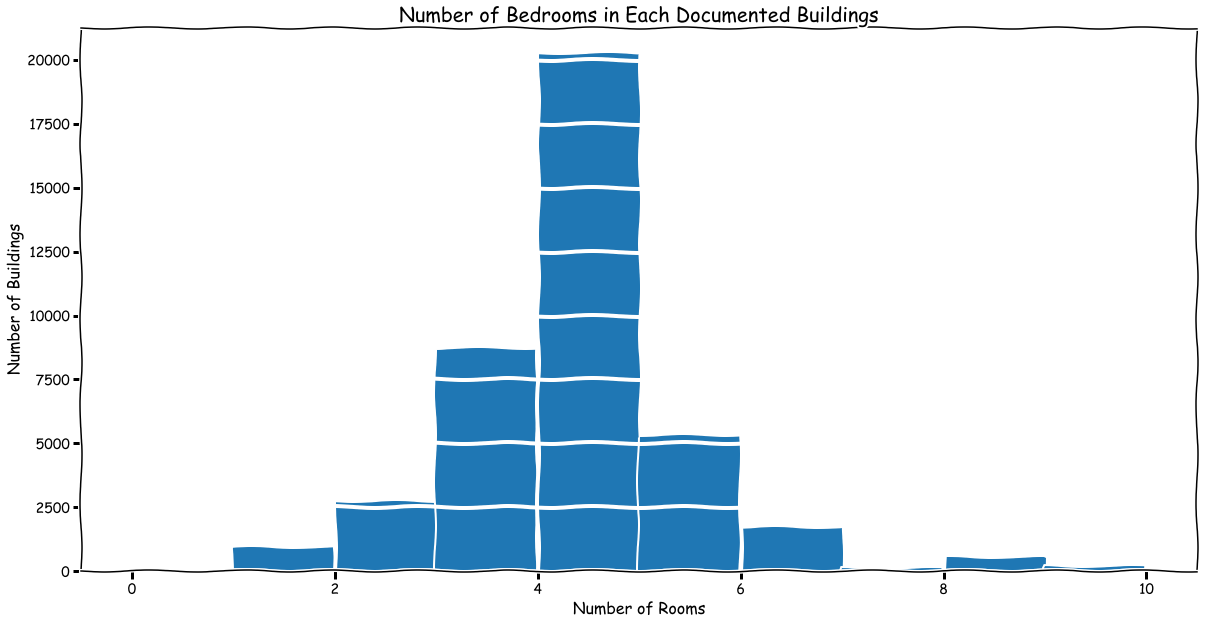

In [18]:
no_bedrooms = scores["TOTAL NUMBER BEDROOMS"]
plt.hist(no_bedrooms, bins=10, range=(0,10))
plt.title("Number of Bedrooms in Each Documented Buildings",fontsize=20)
plt.xlabel('Number of Rooms', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

## Water and Energy Scores

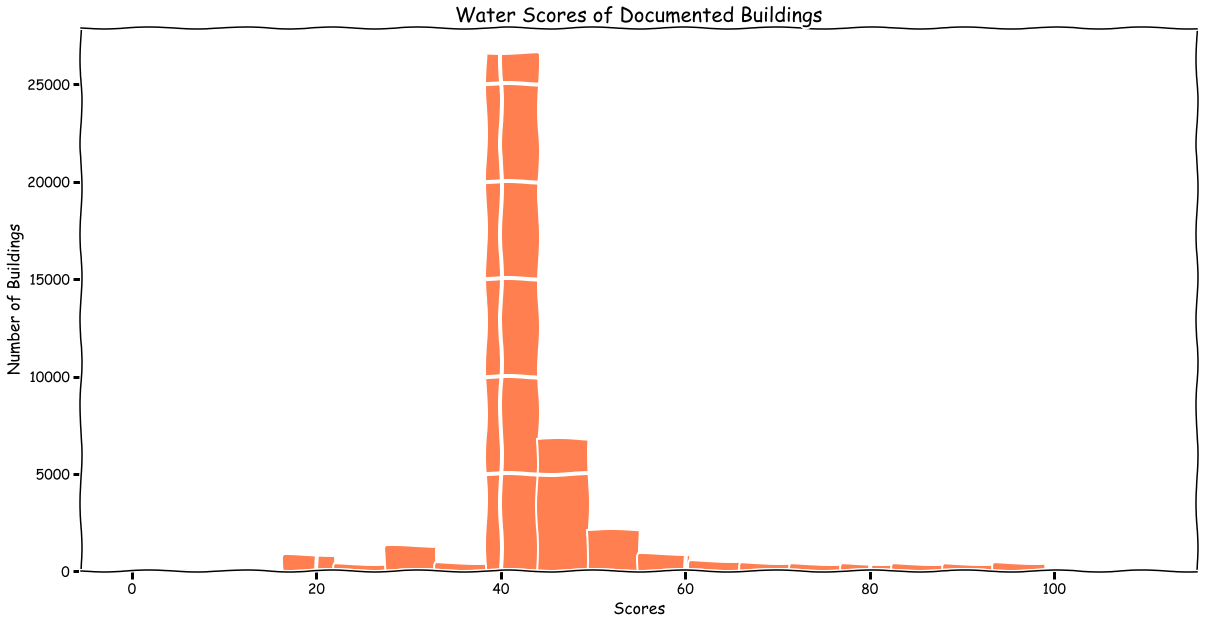

In [19]:
water_score = scores["WATER SCORE"]
plt.hist(water_score, bins=20, range=(0,110), facecolor="coral")
plt.title("Water Scores of Documented Buildings",fontsize=20)
plt.xlabel('Scores', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

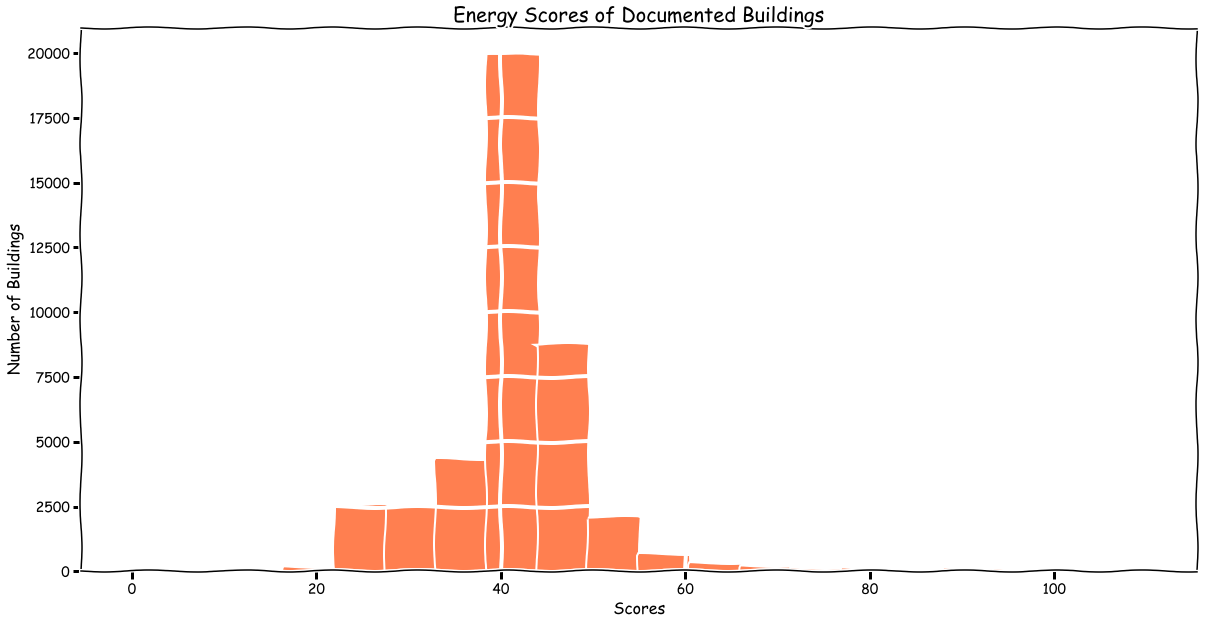

In [20]:
energy_score = scores["ENERGY SCORE"]
plt.hist(energy_score, bins=20, range=(0,110), facecolor="coral")
plt.title("Energy Scores of Documented Buildings",fontsize=20)
plt.xlabel('Scores', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

## Water and Energy Target Scores

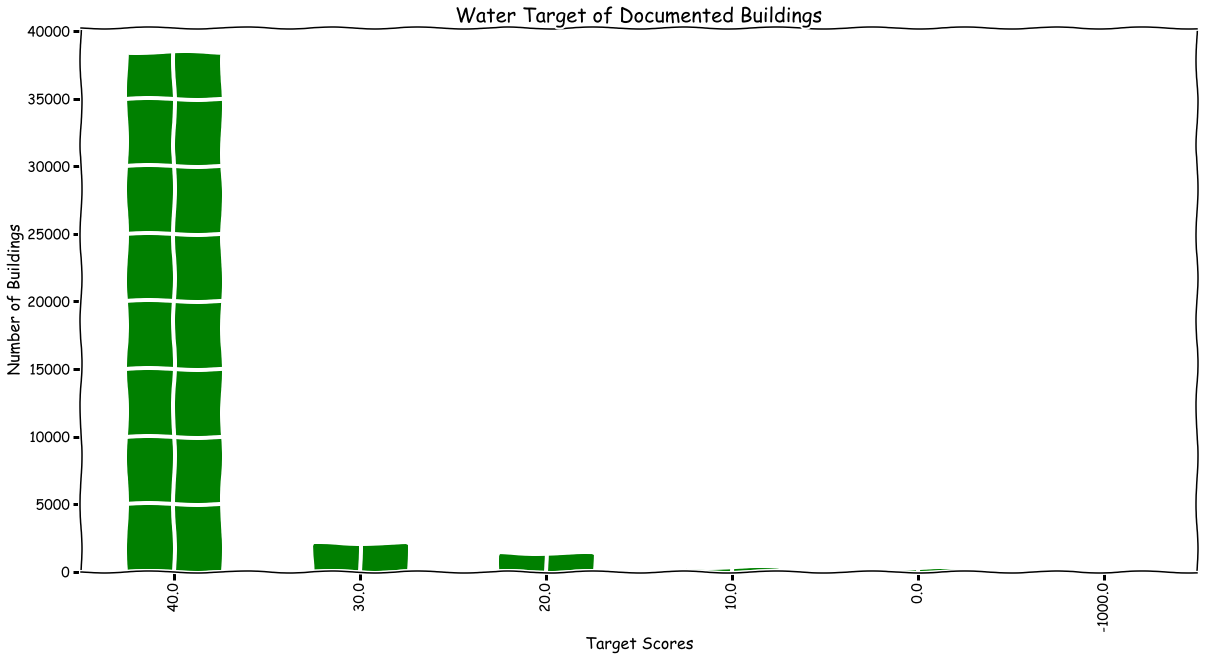

In [21]:
scores["WATER TARGET"].value_counts().plot(kind="bar", facecolor="green")
plt.title("Water Target of Documented Buildings",fontsize=20)
plt.xlabel('Target Scores', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

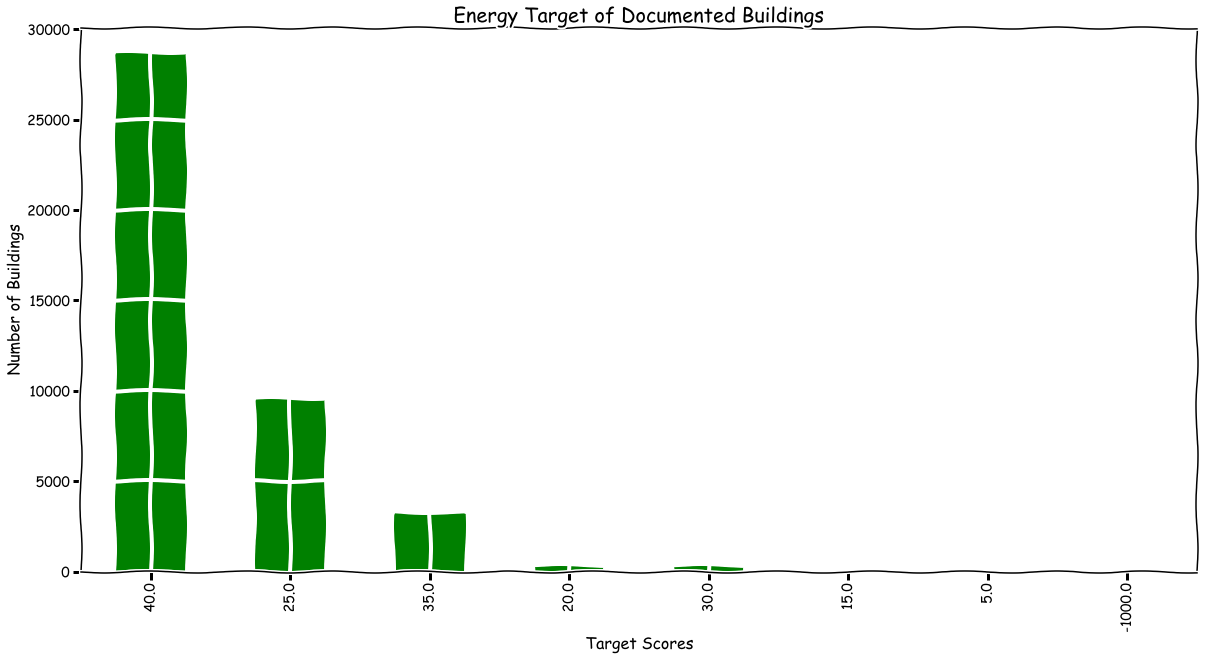

In [22]:
scores["ENERGY TARGET"].value_counts().plot(kind="bar", facecolor="green")
plt.title("Energy Target of Documented Buildings",fontsize=20)
plt.xlabel('Target Scores', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

In [23]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.drop(["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4", "DT_RETIRE"], axis=1, inplace=True)
burbs.head(2)

,DT_CREATE,LC_PLY_PID,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_5,NSW_LOCA_6,NSW_LOCA_7,geometry
0,2015-09-03,25113,NSW1147,2015-11-10,CROYDON PARK,G,None,1,"POLYGON ((151.1170000066 -33.89151546943, 151...."
1,2015-09-03,25065,NSW2557,2015-11-10,MAYFIELD WEST,G,None,1,"POLYGON ((151.73344571654 -32.87974104891, 151..."


DT_CREATE                                            2012-02-16
LC_PLY_PID                                                16612
LOC_PID                                                 NSW2123
NSW_LOCALI                                           2012-05-04
NSW_LOCA_2                                           KENSINGTON
NSW_LOCA_5                                                    G
NSW_LOCA_6                                                 None
NSW_LOCA_7                                                    1
geometry      POLYGON ((151.226736204561 -33.904512307867, 1...
Name: 1735, dtype: object


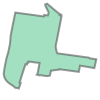

In [24]:
a = burbs.iloc[1735]
print a
a.geometry

In [25]:
def add_centroid(row):
    return row.geometry.centroid

burbs["centroid"] = burbs.apply(add_centroid, axis=1)

POINT (151.1028906456905 -33.89725556028139)


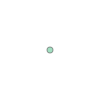

In [26]:
a = burbs.iloc[0]
print a.centroid
a.centroid

In [27]:
burbs.head()

,DT_CREATE,LC_PLY_PID,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_5,NSW_LOCA_6,NSW_LOCA_7,geometry,centroid
0,2015-09-03,25113,NSW1147,2015-11-10,CROYDON PARK,G,None,1,"POLYGON ((151.1170000066 -33.89151546943, 151....",POINT (151.1028906456905 -33.89725556028139)
1,2015-09-03,25065,NSW2557,2015-11-10,MAYFIELD WEST,G,None,1,"POLYGON ((151.73344571654 -32.87974104891, 151...",POINT (151.7246099649729 -32.88497041458911)
2,2015-09-03,25115,NSW797,2015-11-10,CAMPSIE,G,None,1,"POLYGON ((151.1072750656 -33.9017926364, 151.1...",POINT (151.1028579688347 -33.91231130168283)
3,2011-11-22,16193,NSW4136,2012-02-04,WALLACETOWN,G,None,1,"POLYGON ((147.450924738497 -34.9651865379095, ...",POINT (147.472286229532 -34.97483543749741)
4,2015-09-03,24884,NSW812,2015-11-10,CANTERBURY,G,None,1,"POLYGON ((151.11758210952 -33.90297173141, 151...",POINT (151.1160651266154 -33.91235927742964)


## Allocation of Documented Buildings on Map

In [28]:
house_sub = scores["SUBURB"].value_counts()

house_sub = house_sub.to_frame(name="count")
house_sub["suburb"] = house_sub.index
house_sub.head()

,count,suburb
KELLYVILLE,1103,KELLYVILLE
WEROMBI,843,WEROMBI
TELARAH,755,TELARAH
BADGERYS CREEK,726,BADGERYS CREEK
YARRAMALONG,652,YARRAMALONG


In [29]:
newmap = pd.merge(burbs, house_sub, left_on="NSW_LOCA_2", right_on="suburb")
newmap.head()

,DT_CREATE,LC_PLY_PID,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_5,NSW_LOCA_6,NSW_LOCA_7,geometry,centroid,count,suburb
0,2015-09-03,25113,NSW1147,2015-11-10,CROYDON PARK,G,None,1,"POLYGON ((151.1170000066 -33.89151546943, 151....",POINT (151.1028906456905 -33.89725556028139),46,CROYDON PARK
1,2015-09-03,25115,NSW797,2015-11-10,CAMPSIE,G,None,1,"POLYGON ((151.1072750656 -33.9017926364, 151.1...",POINT (151.1028579688347 -33.91231130168283),38,CAMPSIE
2,2015-09-03,24884,NSW812,2015-11-10,CANTERBURY,G,None,1,"POLYGON ((151.11758210952 -33.90297173141, 151...",POINT (151.1160651266154 -33.91235927742964),36,CANTERBURY
3,2015-09-03,24885,NSW1359,2015-11-10,EARLWOOD,G,None,1,"POLYGON ((151.14016397916 -33.91626727655, 151...",POINT (151.1273887902376 -33.9246796668678),59,EARLWOOD
4,2015-09-03,25102,NSW3578,2015-11-10,SILVERWATER,G,None,1,"POLYGON ((151.05436177755 -33.82846392023, 151...",POINT (151.0462794401547 -33.83422709541295),4,SILVERWATER


In [30]:
newmap[newmap["NSW_LOCA_2"]=="KELLYVILLE"]

,DT_CREATE,LC_PLY_PID,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_5,NSW_LOCA_6,NSW_LOCA_7,geometry,centroid,count,suburb
235,2016-12-12,27168,NSW2112,2017-02-02,KELLYVILLE,G,None,1,"POLYGON ((150.93351790885 -33.65978778029, 150...",POINT (150.9536370035998 -33.69950814221832),1103,KELLYVILLE


In [31]:
right_here = shapely.geometry.point.Point(151.2299732, -33.9178754)
newmap["distance_from_UNSW"] = newmap.geometry.distance(right_here)

In [32]:
kellyville = shapely.geometry.point.Point(150.9536370035998, -33.69950814221832)
newmap["distance_from_KELLYVILLE"] = newmap.geometry.distance(kellyville)

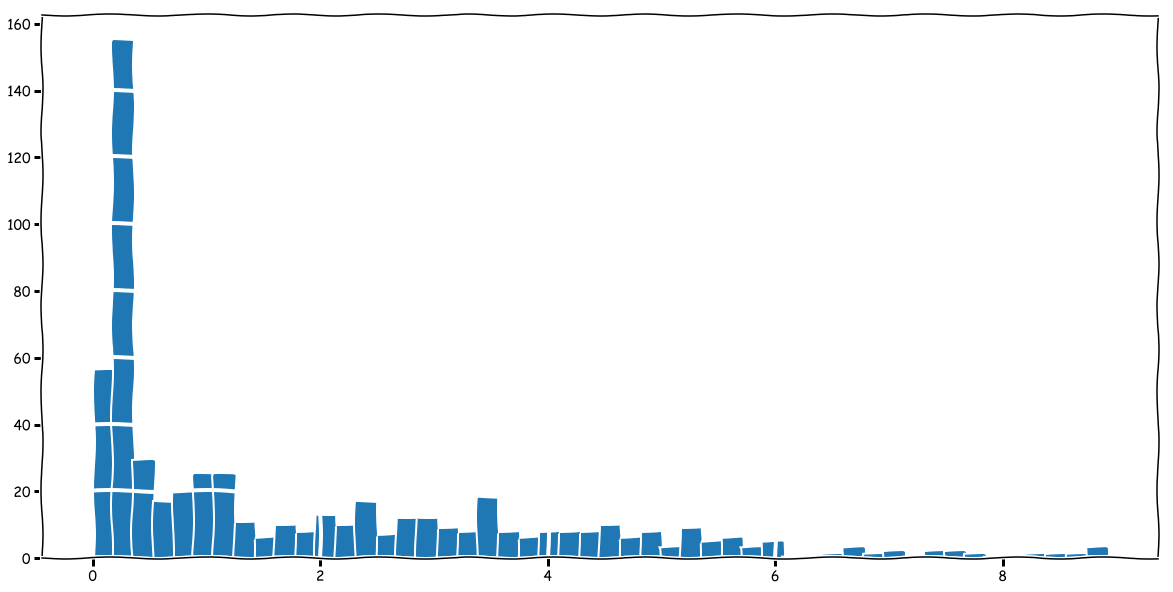

In [33]:
newmap.distance_from_KELLYVILLE.hist(bins=50)

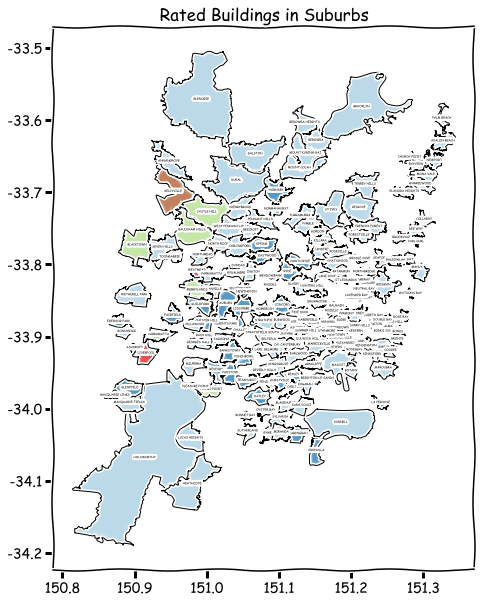

In [34]:
final = newmap[newmap.distance_from_UNSW<0.35]
final.plot(column='count', cmap='Paired')
for idx, row in final.iterrows():
    plt.annotate(s=row.NSW_LOCA_2, 
                 xy=tuple(row.centroid.coords)[0],
                 horizontalalignment='center',
                 fontsize=3)
plt.title("Rated Buildings in Suburbs");

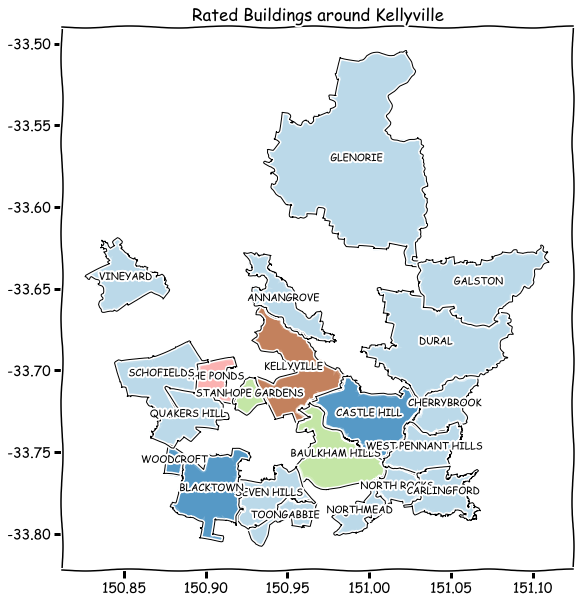

In [35]:
most_rated = newmap[newmap.distance_from_KELLYVILLE<0.1]
most_rated.plot(column='count', cmap='Paired')
for idx, row in most_rated.iterrows():
    plt.annotate(s=row.NSW_LOCA_2, 
                 xy=tuple(row.centroid.coords)[0],
                 horizontalalignment='center',
                 fontsize=10)
plt.title("Rated Buildings around Kellyville");

## Total Saving Facts

- For consumption of electricity, the CO2 emission factor used is 0.527 kg / kWh.
- The CO2 generated by burning natural gas is 0.185 kg / kWh

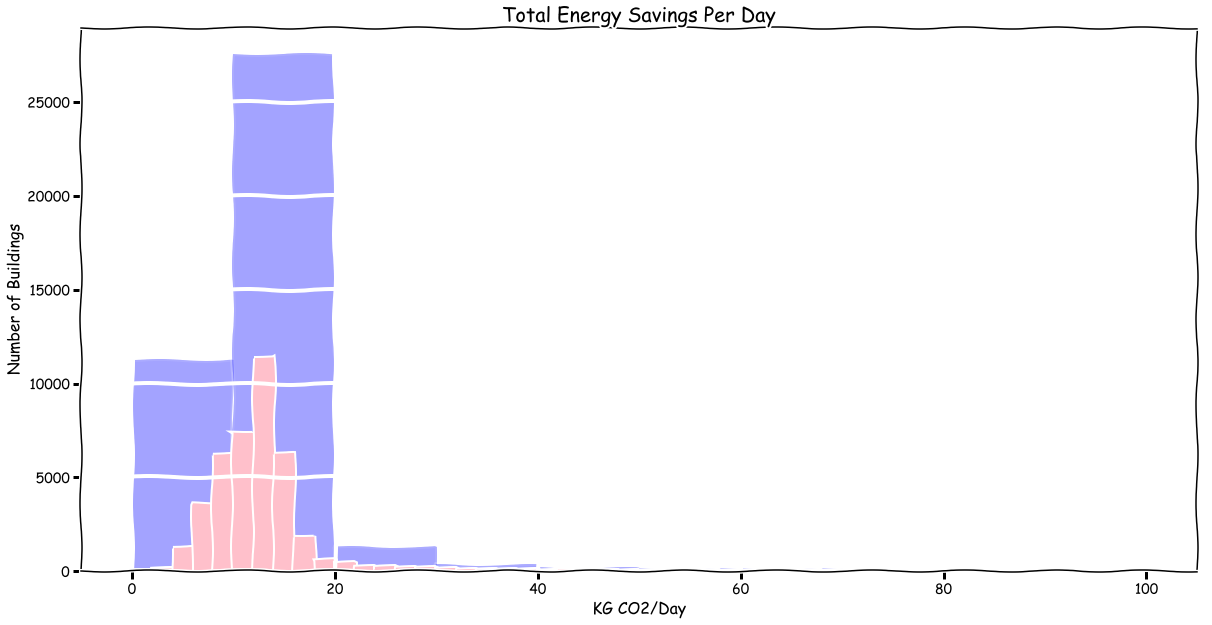

In [36]:
energy_saving = scores["TOTAL ENERGY SAVINGS PER DAY (KG CO2 PER DAY)"]
plt.hist(energy_saving, bins=10, facecolor="blue", alpha=0.2, range=(0,100))
plt.hist(energy_saving, bins=50, facecolor="pink", alpha=1, range=(0,100))
plt.title("Total Energy Savings Per Day",fontsize=20)
plt.xlabel('KG CO2/Day', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()


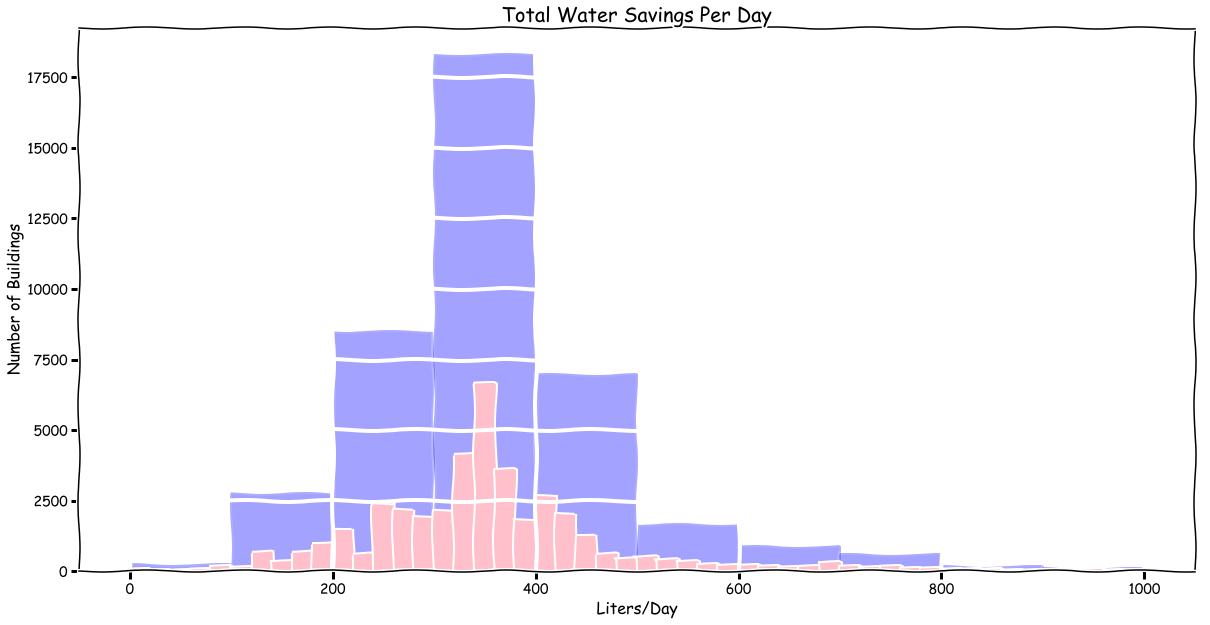

In [37]:
water_saving = scores["TOTAL WATER SAVINGS PER DAY (LITRES PER DAY)"]
plt.hist(water_saving, bins=10, facecolor="blue", alpha=0.2, range=(0,1000))
plt.hist(water_saving, bins=50, facecolor="pink", alpha=1, range=(0,1000))
plt.title("Total Water Savings Per Day",fontsize=20)
plt.xlabel('Liters/Day', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

## Hot Water System Facts

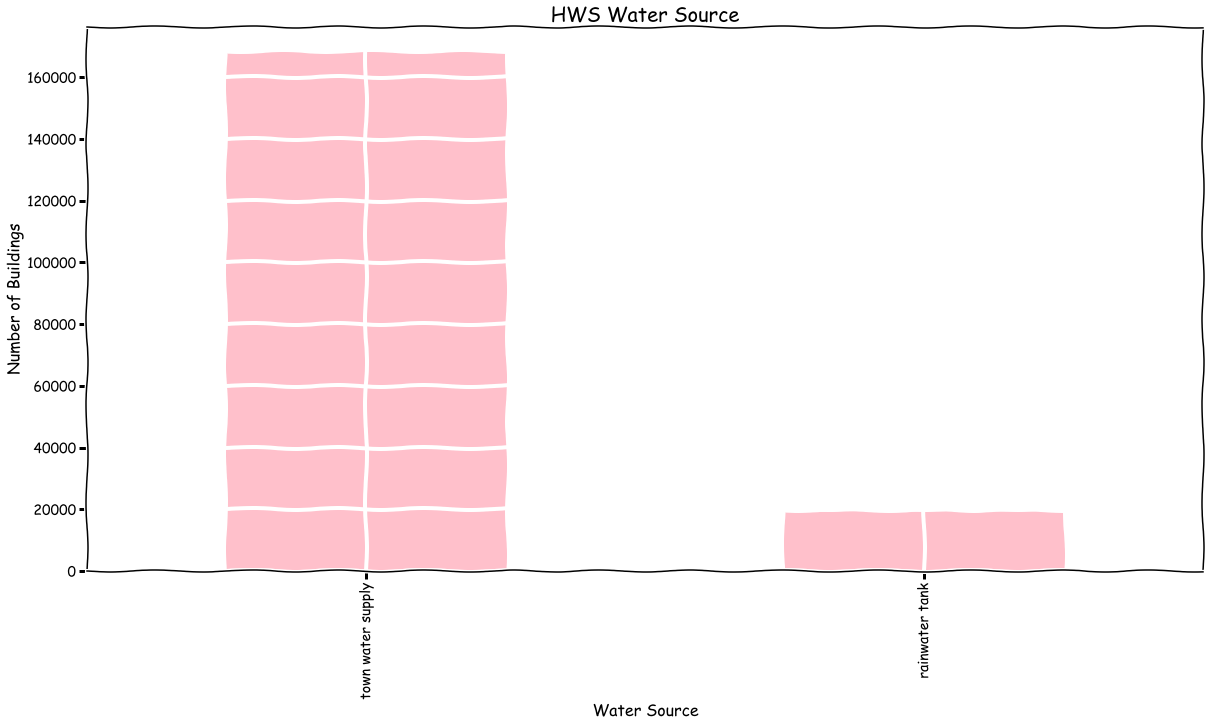

In [38]:
water["HOT WATER SYSTEM WATER SOURCE"].value_counts().plot(kind="bar", facecolor="pink")
plt.title("HWS Water Source",fontsize=20)
plt.xlabel('Water Source', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

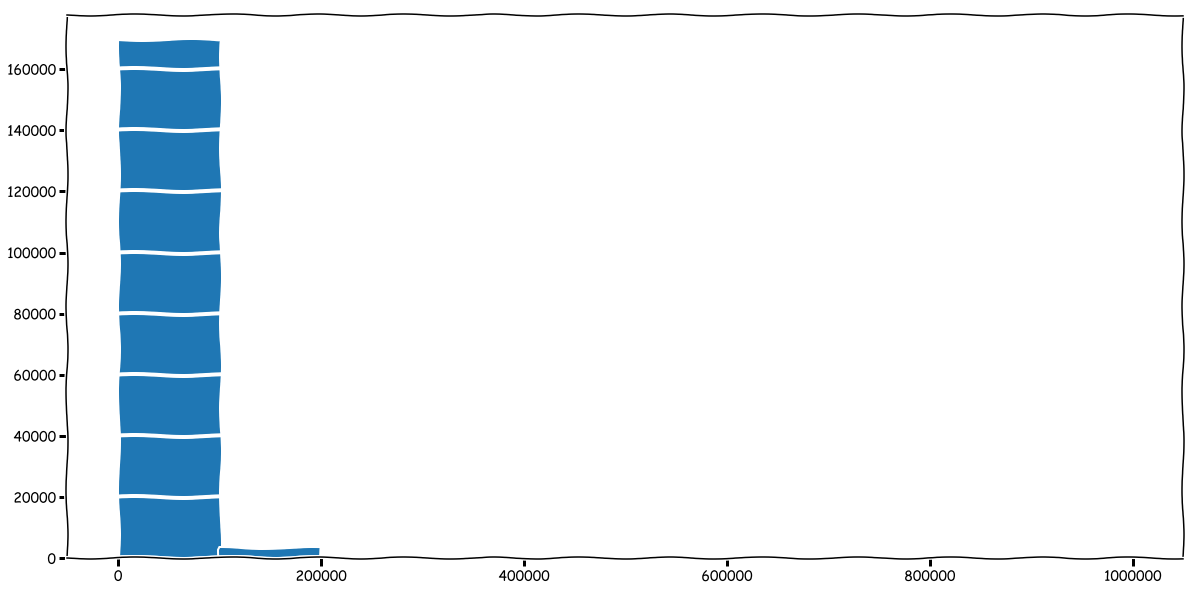

In [39]:
rain_tank_size = water["RAINWATER TANK SIZE (litres)"]
rain_tank_size.hist()

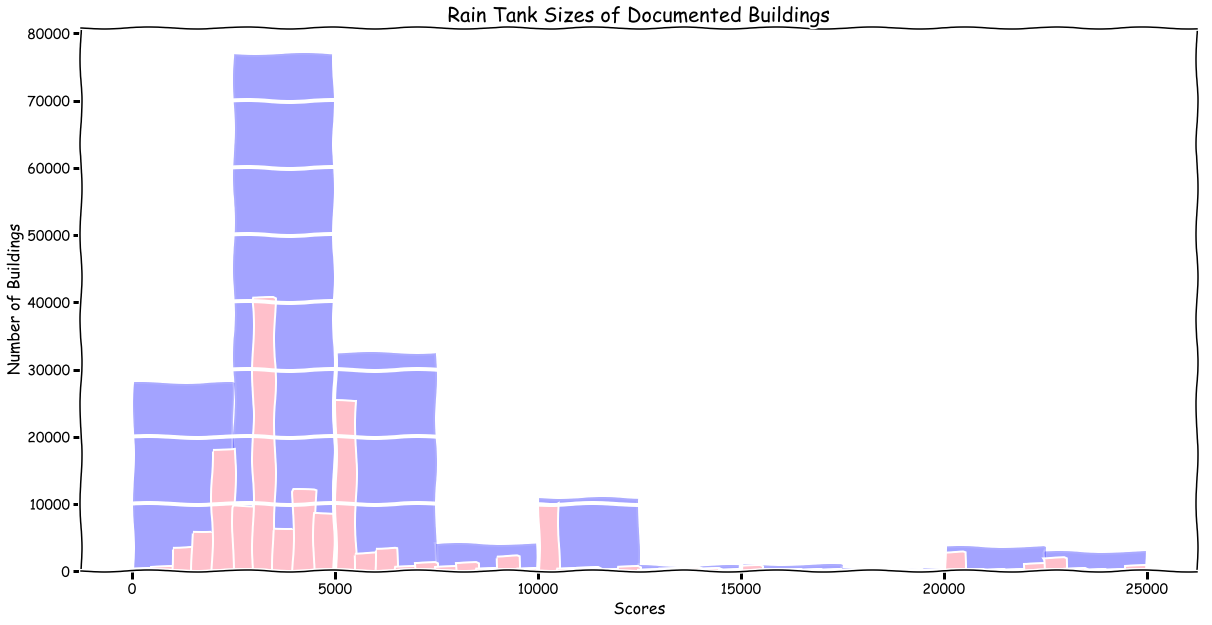

In [40]:

plt.hist(rain_tank_size, bins=10, facecolor='blue', alpha=0.2, range=(0,25000))
plt.hist(rain_tank_size, bins=50, facecolor='pink', alpha=1, range=(0,25000))
plt.title("Rain Tank Sizes of Documented Buildings",fontsize=20)
plt.xlabel('Scores', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

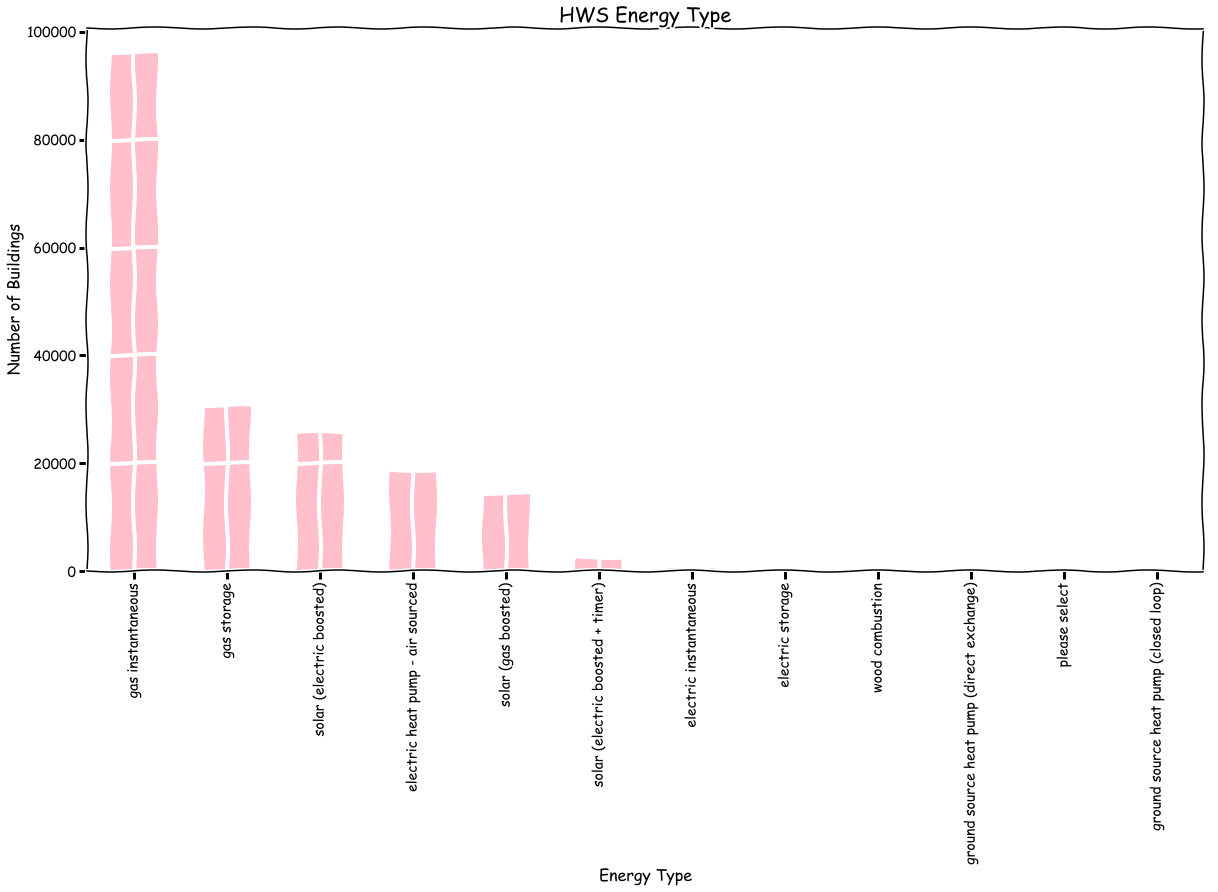

In [41]:
energy["HOTWATER SYSTEM TYPE"].value_counts().plot(kind="bar", facecolor="pink")
plt.title("HWS Energy Type",fontsize=20)
plt.xlabel('Energy Type', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

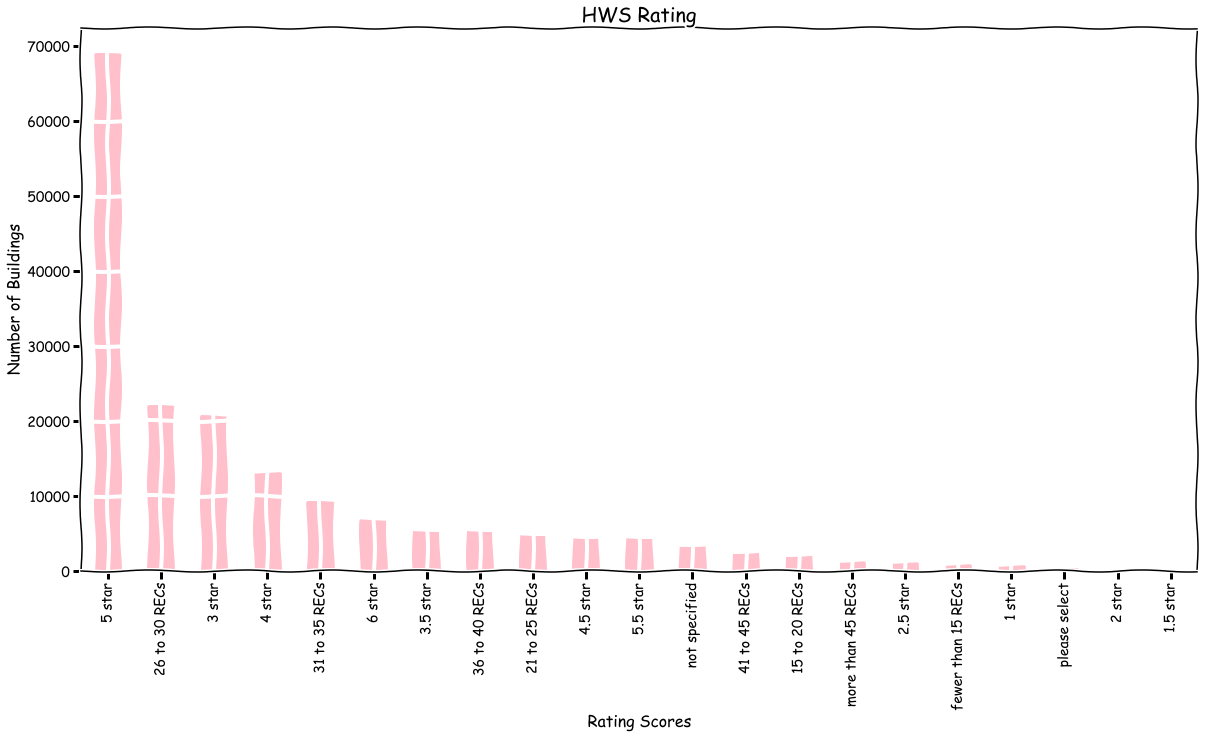

In [42]:
energy["HWS RATING (STARS/RECS)"].value_counts().plot(kind="bar", facecolor="pink")
plt.title("HWS Rating",fontsize=20)
plt.xlabel('Rating Scores', fontsize=16)
plt.ylabel('Number of Buildings', fontsize=16)
plt.grid(True)
plt.show()

## Conclusion

- over 80% buildings are single dwellings.
- half of the buildings accomadates 4-5 bedrooms.
- over half of the buildings are scored 40 in water & energy ratings, just meet the target.
- significant amount of registered buildings in the Northwest
- most of the buildings save less than 20 liters water per day.
- 10% of the households use rainwater tanks as resource for hot water.
- gas is the dominate energy resource for hot water system.

In [43]:
water.columns

Index([u'Id', u'CERTIFICATE DATE', u'REGION', u'LGA', u'POSTCODE', u'SUBURB',
       u'DATA SET', u'DWELLING TYPE', u'RAINWATER TANK SIZE (litres)',
       u'STORM WATER TANK SIZE (litres)',
       u'RAINWATER TANK ROOF COLLECTION AREA (SqM)', u'TOILET WATER SOURCE',
       u'GARDEN AND LAWN WATER SOURCE', u'LAUNDRY WATER SOURCE',
       u'HOT WATER SYSTEM WATER SOURCE', u'ALL HOUSE WATER SOURCE',
       u'SHOWER WELS RATING', u'BATHROOM TAPS WELS RATING',
       u'TOILET WELS RATING', u'KITCHEN TAPS WELS RATING',
       u'POOL SIZE (kilo litres)', u'SPA SIZE (kilo litres)'],
      dtype='object')

In [44]:
water.head()

,Id,CERTIFICATE DATE,REGION,LGA,POSTCODE,SUBURB,DATA SET,DWELLING TYPE,RAINWATER TANK SIZE (litres),STORM WATER TANK SIZE (litres),...,GARDEN AND LAWN WATER SOURCE,LAUNDRY WATER SOURCE,HOT WATER SYSTEM WATER SOURCE,ALL HOUSE WATER SOURCE,SHOWER WELS RATING,BATHROOM TAPS WELS RATING,TOILET WELS RATING,KITCHEN TAPS WELS RATING,POOL SIZE (kilo litres),SPA SIZE (kilo litres)
0,14616,5-Aug-05,Hunter,Lake Macquarie City Council,2285,GLENDALE,single dwellings,Single dwelling houses,2500.0,NaN,...,rainwater tank,rainwater tank,town water supply,town water supply,3 star,6 star,3 star,3 star,NaN,NaN
1,14663,4-Aug-05,Murray/Murrumbidgee,Palerang Council,2621,BUNGENDORE,single dwellings,Single dwelling houses,22000.0,NaN,...,greywater system,town water supply,rainwater tank,town water supply,3 star,6 star,3 star,3 star,NaN,NaN
2,14708,5-Aug-05,Hunter,Lake Macquarie City Council,2281,SWANSEA,single dwellings,Single dwelling houses,6000.0,NaN,...,rainwater tank,rainwater tank,town water supply,town water supply,3 star,6 star,3 star,3 star,NaN,NaN
3,14943,8-Aug-05,Sydney,Penrith City Council,2745,WALLACIA,single dwellings,Single dwelling houses,7500.0,NaN,...,rainwater tank,rainwater tank,town water supply,town water supply,3 star,5 star,1 star,please select,NaN,NaN
4,16571,25-Aug-05,Southern,Shellharbour City Council,2529,SHELLHARBOUR SQUARE,single dwellings,Multi-dwelling houses,3000.0,NaN,...,rainwater tank,town water supply,town water supply,town water supply,3 star,6 star,3 star,3 star,NaN,NaN


In [45]:
energy.head()

,Id,CERTIFICATE DATE,REGION,LGA,POSTCODE,SUBURB,DATA SET,DWELLING TYPE,HOTWATER SYSTEM TYPE,HWS RATING (STARS/RECS),...,HEATING RATING - BEDROOMS (STARS/RECS),COOLING TYPE - BEDROOMS,COOLING RATING - BEDROOMS (STARS/RECS),COOKTOP/OVEN SELECTION,PV (kW),NUMBER LIVING AREAS LIT WITH ENERGY EFFICIENT LIGHTING,KITCHEN LIT WITH ENERGY EFFICIENT LIGHTING,NUMBER BEDROOMS LIT WITH ENERGY EFFICIENT LIGHTING,POOL HEATING SYSTEM,SPA HEATING SYSTEM
0,134809,27-Mar-09,North Coast,Nambucca Shire Council,2447,WARRELL CREEK,single dwellings,Single dwelling houses,solar (electric boosted),26 to 30 RECs,...,EER 3.0 - 3.5,3-phase airconditioning,EER 2.5 - 3.0,electric cooktop & electric oven,NaN,NaN,NaN,NaN,please select,please select
1,114779,17-Jul-08,Hunter,Maitland City Council,2323,TENAMBIT,single dwellings,Single dwelling houses,gas storage,5 star,...,NaN,no active cooling system,NaN,electric cooktop & electric oven,NaN,NaN,NaN,NaN,please select,please select
2,134394,26-Mar-09,Sydney,Hawkesbury City Council,2758,KURRAJONG,single dwellings,Single dwelling houses,solar (electric boosted),41 to 45 RECs,...,NaN,no active cooling system,NaN,electric cooktop & electric oven,NaN,3.0,True,6.0,no heating,please select
3,114545,15-Jul-08,Murray/Murrumbidgee,Upper Lachlan Council,2583,TUENA,single dwellings,Single dwelling houses,solar (electric boosted),41 to 45 RECs,...,6 Star,ceiling fans,NaN,gas cooktop & gas oven,NaN,2.0,True,4.0,please select,please select
4,126699,1-Dec-08,Hunter,Cessnock City Council,2320,TELARAH,single dwellings,Single dwelling houses,gas instantaneous,5 star,...,NaN,no active cooling system,NaN,gas cooktop & electric oven,NaN,2.0,True,3.0,please select,please select


In [46]:
energy.columns

Index([u'Id', u'CERTIFICATE DATE', u'REGION', u'LGA', u'POSTCODE', u'SUBURB',
       u'DATA SET', u'DWELLING TYPE', u'HOTWATER SYSTEM TYPE',
       u'HWS RATING (STARS/RECS)', u'HEATING TYPE - LIVING AREA',
       u'HEATING RATING - LIVING AREA (STARS/RECS)',
       u'COOLING TYPE - LIVING AREA',
       u'COOLING RATING - LIVING AREA (STARS/RECS)',
       u'HEATING TYPE - BEDROOMS', u'HEATING RATING - BEDROOMS (STARS/RECS)',
       u'COOLING TYPE - BEDROOMS', u'COOLING RATING - BEDROOMS (STARS/RECS)',
       u'COOKTOP/OVEN SELECTION', u'PV (kW)',
       u'NUMBER LIVING AREAS LIT WITH ENERGY EFFICIENT LIGHTING',
       u'KITCHEN LIT WITH ENERGY EFFICIENT LIGHTING',
       u'NUMBER BEDROOMS LIT WITH ENERGY EFFICIENT LIGHTING',
       u'POOL HEATING SYSTEM', u'SPA HEATING SYSTEM'],
      dtype='object')